In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline

In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

cat


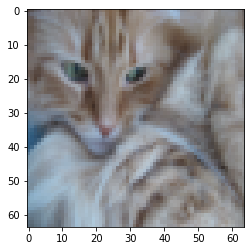

In [14]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

plt.imshow(train_set_x_orig[2])
print(classes[np.squeeze(train_set_y[:,25])].decode('utf-8'))

In [15]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


In [19]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T



train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [20]:
# this is the activation formula
def sigmoid(z):
    s = 1/(1 + np.exp(-z))
    
    return s

In [21]:
#This is to initialize the z above
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float)) or isinstance(b, int)
    
    return w, b

In [22]:
#we want to minimize the cost of this function
def propogate(w, b, X, Y):
    m = X.shape[1]
    
    #forward propogation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1/m) * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A)))
    
    #backward propogation
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {'dw': dw, 'db': db}
    
    return grads, cost

In [23]:
#here is where we optimize the learning
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    
    costs=[]
    
    for i in range(num_iterations):
        
        #cost and gradient calculation
        grads, cost = propogate(w, b, X, Y)
        
        #get derivatives
        dw = grads['dw']
        db = grads['db']
        
        #update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        #record costs
        if i % 100 == 0:
            costs.append(cost)
            
        #Print cost every 100 training examples
        if print_cost and i % 100 == 0:
            print('Cost after iteration %i: %f ' % (i, cost))
    params = {'w': w, 'b': b}
    grads = {'dw': dw, 'db': db}
    
    return params, grads, costs

In [24]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    #Compute probability vector
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > .5 else 0
        
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [27]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=.5, print_cost=False):
    
    #initialize parameters with 0s
    w, b = initialize_with_zeros(X_train.shape[0])
    
    #Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    #Retrieve parameters w, b from dictionary
    w = parameters['w']
    b = parameters['b']
    
    #Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    #Print test/train errors
    print("Train accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Test accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_test-Y_test)) * 100))
    
    d = {'costs': costs,
        'Y_prediction_test': Y_prediction_test,
         'Y_prediction_train': Y_prediction_train,
         'w': w,
         'b': b,
         'learning_rate': learning_rate,
         'num_iterations': num_iterations
        }
    
    return d

In [49]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1000, learning_rate = .0055, print_cost = True)

Cost after iteration 0: 0.693147 
Cost after iteration 100: 0.621910 
Cost after iteration 200: 0.506131 
Cost after iteration 300: 0.408255 
Cost after iteration 400: 0.327046 
Cost after iteration 500: 0.287476 
Cost after iteration 600: 0.264700 
Cost after iteration 700: 0.245427 
Cost after iteration 800: 0.228834 
Cost after iteration 900: 0.214362 
Train accuracy: 97.12918660287082 %
Test accuracy: 70.0 %


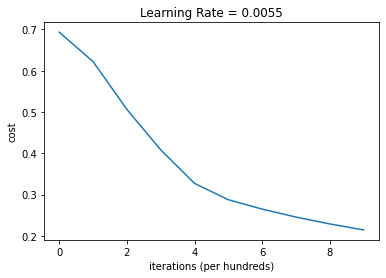

In [50]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning Rate = " + str(d["learning_rate"]))
plt.show()